SUDISH BASNET - 301250603

In [184]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input, Lambda
from keras import Model
from keras import metrics, optimizers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,roc_curve, recall_score, classification_report, f1_score,precision_recall_fscore_support)



1. Import all the necessary libraries, read the dataset using pandas and analyze the data. For data preparation phase, save the “benign” and “attack” dataframe separately. Drop the “Label” column from the dataset and convert benign and attack dataframes to numpy arrays. Now, split the data into test and train (use 75% observations for train set and the remaining 25%
for test set). Then, scale the train and test data using MinMax Scaler. [10% marks].

In [185]:
drive.mount('/content/drive')
df = pd.read_csv('drive/My Drive/network_attack_data.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,...,F_68,F_69,F_70,F_71,F_72,F_73,F_74,F_75,F_76,Label
0,109998919,4,3,525,0.0,520,0,131.25,259.177385,0,...,32,5735.0,0.0,5735.0,5735.0,110000000.0,0.0,110000000.0,110000000.0,1
1,109993343,4,3,531,0.0,520,0,132.75,258.218738,0,...,32,5437.0,0.0,5437.0,5437.0,110000000.0,0.0,110000000.0,110000000.0,1
2,109988359,4,3,535,0.0,520,0,133.75,257.597069,0,...,32,5505.0,0.0,5505.0,5505.0,110000000.0,0.0,110000000.0,110000000.0,1
3,109982960,4,3,530,0.0,520,0,132.50,258.376341,0,...,32,5303.0,0.0,5303.0,5303.0,110000000.0,0.0,110000000.0,110000000.0,1
4,109977744,4,3,530,0.0,520,0,132.50,258.376341,0,...,32,5356.0,0.0,5356.0,5356.0,110000000.0,0.0,110000000.0,110000000.0,1


In [186]:
# save the “benign” and “attack” dataframe separately
benign,attack = df['Label']==0,df['Label']==1
df_benign,df_attack = df[benign],df[attack]
print(df_benign.shape,df_attack.shape)

(22987, 77) (5498, 77)


In [187]:
#Drop the “Label” column from the dataset and convert benign and attack dataframes to numpy arrays
x_benign,y_benign = df_benign.drop('Label',axis = 1).values,df_benign['Label'].values
x_attack,y_attack = df_attack.drop('Label',axis = 1).values,df_attack['Label'].values

In [188]:
# use 75% observations for train set and the remaining 25% for test set
train_x_benign,test_x_benign,train_y_benign,test_y_benign = train_test_split(x_benign,y_benign,random_state=1,test_size=0.25)


In [189]:
# scale the train and test data using MinMax Scaler
minmax = MinMaxScaler()
train_x_benign_trans,test_x_benign_trans = minmax.fit_transform(train_x_benign),minmax.transform(test_x_benign)
x_attack_trans = minmax.fit_transform(x_attack)

2. Set the following hyperparameter values: [5% marks].
• batch_size = 64
• num_features= 76
• latent_dim = 5
• number of neurons in the hidden layers= 100
• epochs = 50

In [190]:
batch_size = 64
num_features = 76
latent_dim = 5 
h1 = 100 
h2 = 100 
epochs = 50

3. Using Keras Functional API, define the encoder, sampling layer, the decoder and instantiate the VAE model. Note both the
encoder and decoder have two hidden layers each. [25% marks]

In [191]:
# Encoder 
inputs = Input(shape=(num_features, ), name='input') #num_features = 76 # number of input features
x1 = Dense(h1, activation='relu')(inputs) ## First hidden layer 
x2 = Dense(h2, activation='relu')(x1) ##Second hidden layer
z_mean = Dense(latent_dim, name='z_mean')(x2) ### Latent layer = 5
z_log_var = Dense(latent_dim, name='z_log_var')(x2) #latent_dim = 5

In [192]:
# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z

In [193]:
# Define Sampling / Latent Layer

z = Lambda(sampling, name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 76)]         0           []                               
                                                                                                  
 dense_25 (Dense)               (None, 100)          7700        ['input[0][0]']                  
                                                                                                  
 dense_26 (Dense)               (None, 100)          10100       ['dense_25[0][0]']               
                                                                                                  
 z_mean (Dense)                 (None, 5)            505         ['dense_26[0][0]']               
                                                                                            

In [194]:
# Decoder

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x1 = Dense(h1, activation='relu')(latent_inputs) ## First hidden layer 
x2 = Dense(h2, activation='relu')(x1) ## Second hidden layer 
outputs = Dense(num_features, activation='sigmoid')(x2) #num_features = 76 # number of input features

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 5)]               0         
                                                                 
 dense_27 (Dense)            (None, 100)               600       
                                                                 
 dense_28 (Dense)            (None, 100)               10100     
                                                                 
 dense_29 (Dense)            (None, 76)                7676      
                                                                 
Total params: 18,376
Trainable params: 18,376
Non-trainable params: 0
_________________________________________________________________


In [195]:
# Instantiate VAE mdoel 
#  VAE model = encoder + decoder

outputs = decoder(encoder(inputs)[2])  # Select the z value from outputs of the encoder
vae = Model(inputs, outputs, name='vae')

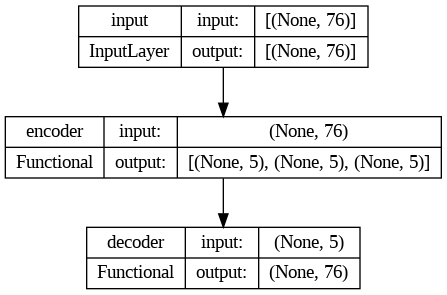

In [196]:
# Plot model
keras.utils.plot_model(vae, "VAE_MODEL.png", show_shapes=True)

4. Define the VAE loss function and compile the model using this loss metric and optimizer to be used is Adam. The learning rate
value must be 0.001. [10% marks]

In [197]:
# VAE Loss
# Reconstruction loss
reconstruction_loss = tf.losses.mean_squared_error(inputs, outputs)
reconstruction_loss = reconstruction_loss * num_features

# KL Divergence loss
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
adam = optimizers.Adam(learning_rate=0.001)
vae.compile(optimizer=adam) ##compile the model
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 76)]         0           []                               
                                                                                                  
 encoder (Functional)           [(None, 5),          18810       ['input[0][0]']                  
                                 (None, 5),                                                       
                                 (None, 5)]                                                       
                                                                                                  
 decoder (Functional)           (None, 76)           18376       ['encoder[0][2]']                
                                                                                                

5. Train the model with batch_size and epochs set above. Display the loss curve during training. Then save the encoder, decoder
and vae models (in .h5 format) using model.save. [15% marks].

In [198]:
# Fit Model

history = vae.fit(train_x_benign_trans, train_y_benign, verbose = 1, 
                  batch_size=batch_size, epochs=epochs,shuffle=True,validation_split=0.2)

Epoch 1/50
216/216 [==============================] - 2s 5ms/step - loss: 3.0870 - val_loss: 1.4660
Epoch 2/50
216/216 [==============================] - 1s 4ms/step - loss: 1.4418 - val_loss: 1.4427
Epoch 3/50
216/216 [==============================] - 1s 4ms/step - loss: 1.4346 - val_loss: 1.4453
Epoch 4/50
216/216 [==============================] - 1s 4ms/step - loss: 1.4280 - val_loss: 1.4404
Epoch 5/50
216/216 [==============================] - 1s 4ms/step - loss: 1.4218 - val_loss: 1.4307
Epoch 6/50
216/216 [==============================] - 1s 4ms/step - loss: 1.4174 - val_loss: 1.4279
Epoch 7/50
216/216 [==============================] - 1s 4ms/step - loss: 1.4160 - val_loss: 1.4249
Epoch 8/50
216/216 [==============================] - 1s 4ms/step - loss: 1.4111 - val_loss: 1.4255
Epoch 9/50
216/216 [==============================] - 1s 4ms/step - loss: 1.4111 - val_loss: 1.4279
Epoch 10/50
216/216 [==============================] - 1s 6ms/step - loss: 1.4088 - val_loss: 1.4165

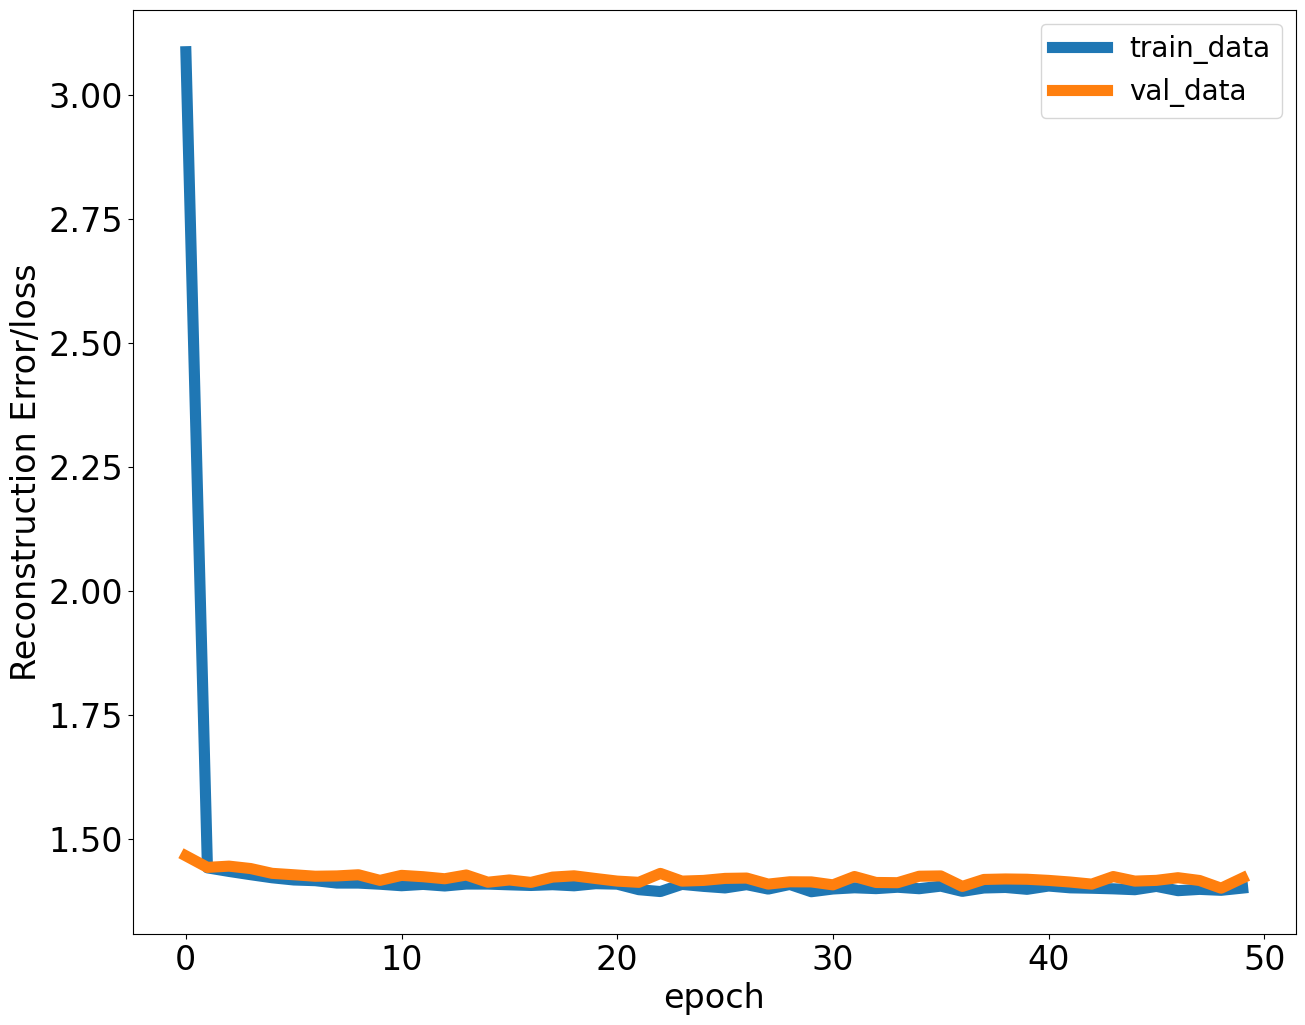

In [199]:
# loss plot train-validation
import matplotlib as mpl

mpl.rcParams['font.size'] = 24
plt.rcParams["figure.figsize"] = (15,12)
plt.plot(history.history['loss'],linewidth = 8)
plt.plot(history.history['val_loss'],linewidth = 8)
#plt.title('model loss',fontsize = 24)
plt.ylabel('Reconstruction Error/loss',fontsize = 24)
plt.xlabel('epoch',fontsize = 24)
plt.legend(['train_data', 'val_data'], loc='best',fontsize = 20)
plt.show()

In [200]:
# Save Model
vae.save("vae.h5") ## save the pre-trained model for later use

6. Make predictions on test data using .predict() and visualize your plot comparing benign observations with attack observations.
Select the most appropriate threshold value by observing the graph and using trial and error approach. [20% marks].

In [201]:
# Combine the Test and Attack Data
test_obs = test_x_benign_trans.copy()
test_obs = np.append(test_obs, x_attack_trans, axis=0)
y_obs = test_y_benign
y_obs = np.append(y_obs, y_attack, axis=0)


# Predict on Test an Attack Data
test_preds=vae.predict(test_obs) # TEST NORMAL+TEST FRAUD
mse_test = np.mean(np.power(test_obs - test_preds, 2), axis=1)   
print(mse_test.shape, y_obs.shape)

tst_error_data = pd.DataFrame({'recon_error': mse_test,'Class': y_obs})
tst_error_data

352/352 [==============================] - 1s 2ms/step
(11245,) (11245,)


,recon_error,Class
0,0.012821,0
1,0.015626,0
2,0.006161,0
3,0.037344,0
4,0.007995,0
...,...,...
11240,0.139254,1
11241,0.138843,1
11242,0.154252,1
11243,0.114662,1


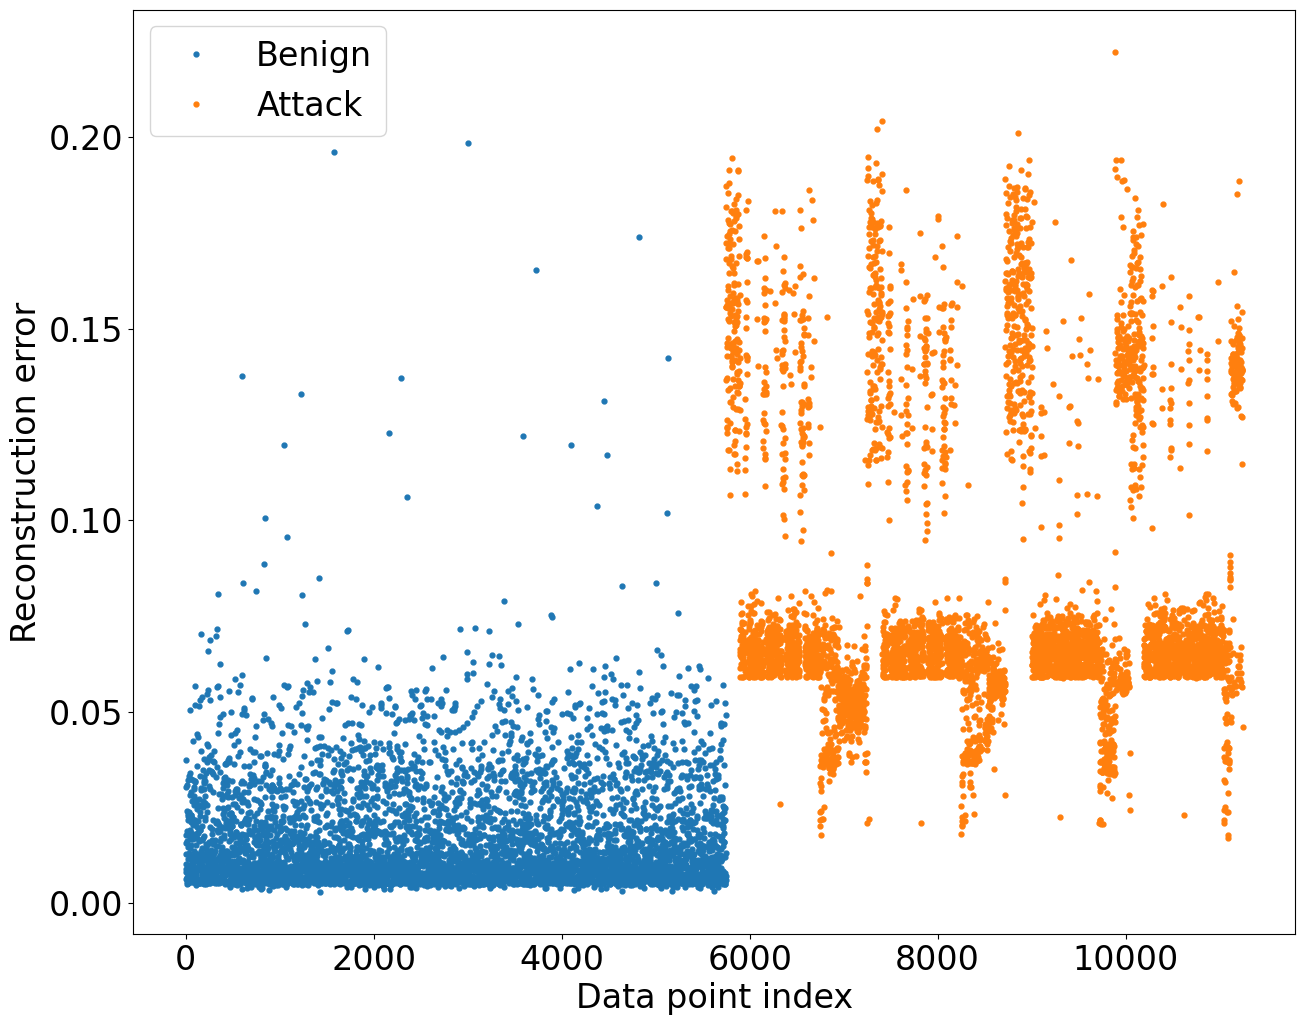

In [202]:
# plot comparing benign observations with attack observations. 
group1 = tst_error_data.groupby('Class')
fig, ax = plt.subplots()
for name, group in group1:
    ax.plot(group.index, group.recon_error, marker='o', ms=3.5, linestyle='',label= "Attack" if name == 1 else "Benign")
ax.legend()
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

5. Perform the metric analysis to evaluate the performance of your classifier at your selected threshold. Display the results in
terms of TPR, FPR, TNR, FNR, Precision, F1_score and ROC-AUC graph.

In [203]:
# TPR, FPR, TNR, FNR, Precision, F1 Score

threshold=0.05 ##selected using trial and error based on improving the TPR and TNR values

y_pred = [1 if e > threshold else 0 for e in tst_error_data.recon_error.values]

cm= confusion_matrix(tst_error_data.Class, y_pred)
print("Confusion matrix:")
print(cm)

tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

print("\nTotal number of true positives", tp)
print("Total number of false negatives",fn)
print("Total number of false positives",fp)
print("Total number of true negatives",tn)

acc=float(tp+tn)/(tp+tn+fp+fn)

print('\nClassifier Accuracy: %.2f%%' % (acc * 100))

tpr = float(tp)/(tp+fn)

print('True Positive Rate (TPR/Recall/Sensitivity): %.2f%%' % (tpr * 100))

specificity = float (tn)/(tn+fp)

print ("True Negative Rate (TNR/Specificity/selectivity):%.2f%%" % (specificity*100)) 

fpr = float(fp)/(fp+tn)
print("False Positive Rate (FPR): %.2f%%" % (fpr * 100))

fnr = fn/ (fn+ tp)
print("False Negative Rate (FNR): %.2f%%" % (fnr*100))

precision=float(tp)/(tp+fp)
print("Precision/Positive Predictive value:%.2f%%" %(precision*100))

fscore = 2*((precision*tpr)/(precision+tpr))
print("F1-Score: %.2f%%" %(fscore*100))

Confusion matrix:
[[5528  219]
 [ 463 5035]]

Total number of true positives 5035
Total number of false negatives 463
Total number of false positives 219
Total number of true negatives 5528

Classifier Accuracy: 93.94%
True Positive Rate (TPR/Recall/Sensitivity): 91.58%
True Negative Rate (TNR/Specificity/selectivity):96.19%
False Positive Rate (FPR): 3.81%
False Negative Rate (FNR): 8.42%
Precision/Positive Predictive value:95.83%
F1-Score: 93.66%


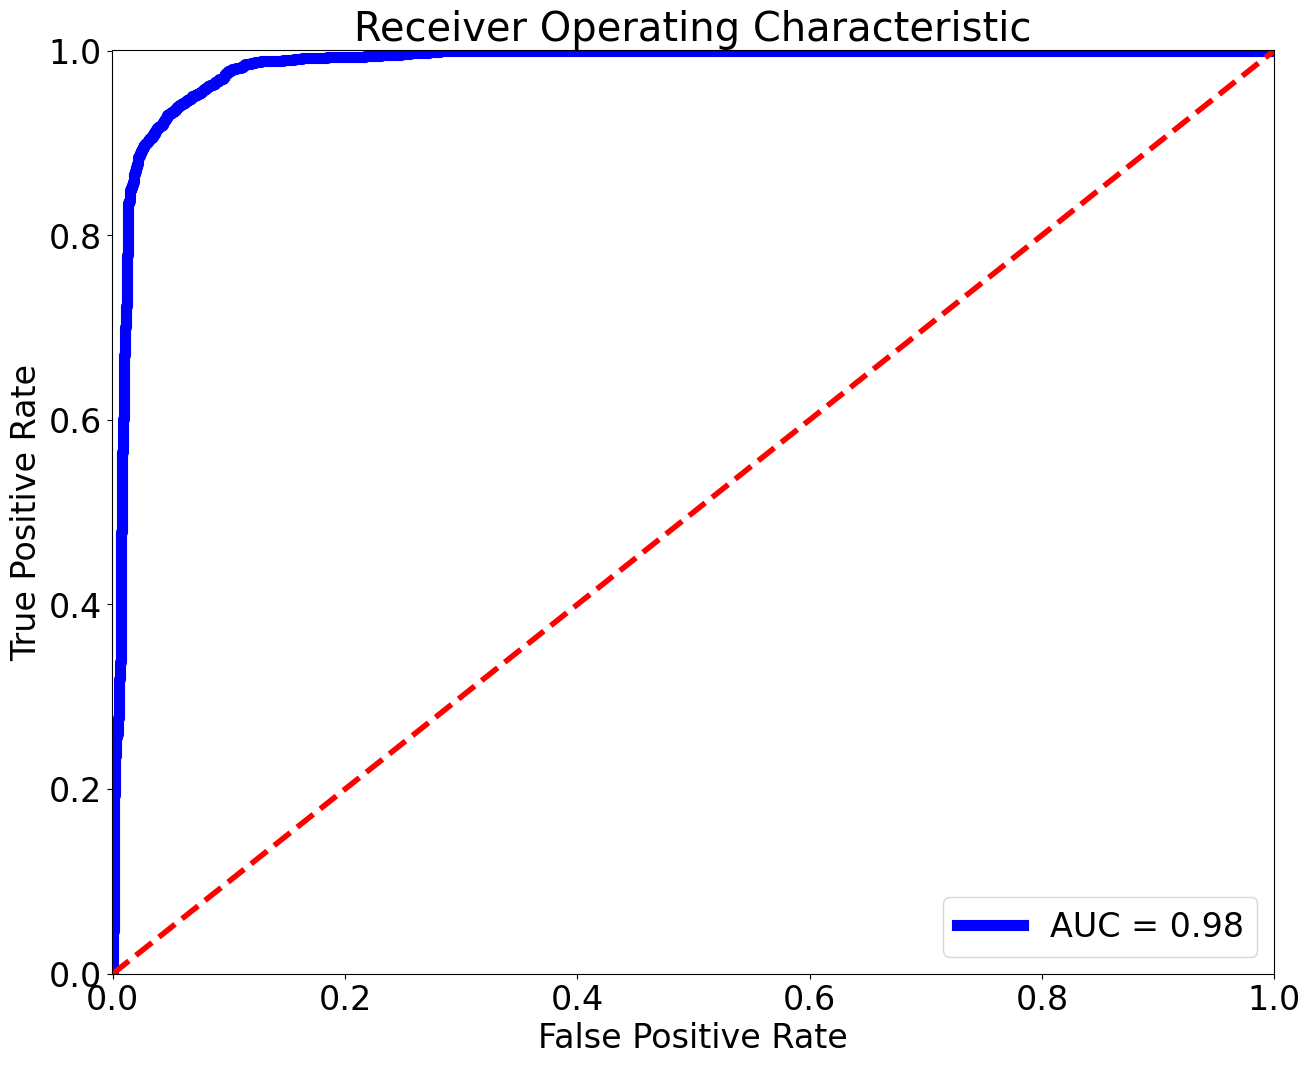

In [204]:
# ROC AUC


fpr, tpr, thresholds = roc_curve(tst_error_data.Class,tst_error_data.recon_error)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc,linewidth = 8, color='b')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--',linewidth = 4)
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()